<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-5/Image_Normalization_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Norm, Batch Norm and L2 Regularization

- We test on 3 different architectures all which gave 99.4% after fine tuning.
- Image and Batch Norm help increase regularization and lower covariate shift.
- Batch Norm also stablises the network since huge activations are normalized. As a result larger learning rates can be used. 
- As a result we will increase `lr` after we have tested our vanilla networks from assignment-4, thereby needing less epochs


In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [2]:
import pandas as pd
import numpy as np
import time
import gc
import os
import sys
import dill
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, SpatialDropout2D
from keras.layers import Convolution2D, MaxPooling2D
import warnings
from data_science_utils.vision.keras import *
from keras.layers import Activation
warnings.filterwarnings("ignore")
%matplotlib inline
from keras.layers import Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Nadam, Adam
import tensorflow_probability as tfp
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Architecture 3


## Vanilla Network from assignment - 4 (Our control group)

In [0]:

X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=True)

In [4]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=40, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.52% with 50 epochs

# 99.45%, 99.40%, 99.32%, 99.38%, 99.39% 99.48%, 99.49% 99.43% 99.32%  with 40 epochs

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Params =  12846
Instructions for updating:
Use tf.cast instead.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_1', 'dropout_1', 'conv2d_2', 'conv2d_3', 'dropout_2', 'max_pooling2d_1', 'conv2d_4', 'dropout_3', 'conv2d_5', 'dropout_4', 'conv2d_6', 'dropout_5', 'conv2d_7', 'conv2d_8', 'flatten_1', 'activation_1']
Validation Loss (0.019823411321640016, 0.9937999997138977)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 

Compute filters 0 to 32
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 32 filter processed.
Filter Losses:  [4.11787, 4.95341, 8.671326, 3.8493001, 5.4691157, 3.9416652, 3.2905042, 0.0, 2.8499365, 5.6701903, 5.677799, 5.794239, 4.666344, 2.9494207, 5.204789, 6.5251193, 2.772279, 7.293513, 4.6923356, 0.0, 3.9821045, 3.734862, 4.86692, 4.8304377, 3.1474195, 5.3531795, 4.960196, 0.0, 3.1563363, 4.80113, 8.281451, 6.1620393]


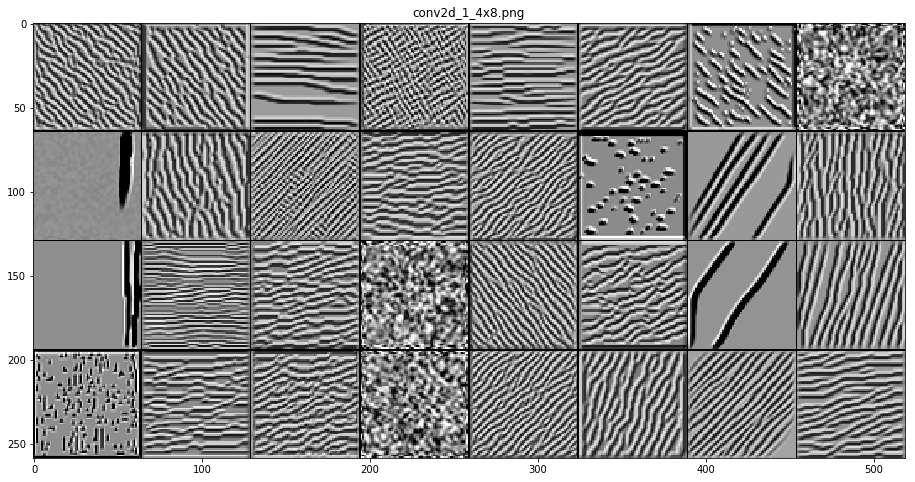

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [13.776486, 7.338174, 16.166836, 8.815412, 7.590076, 9.203388, 5.5216627, 7.976393, 13.6976, 1.7556081, 9.804084, 13.18936, 18.599604, 13.273926, 9.852473, 3.5551393]


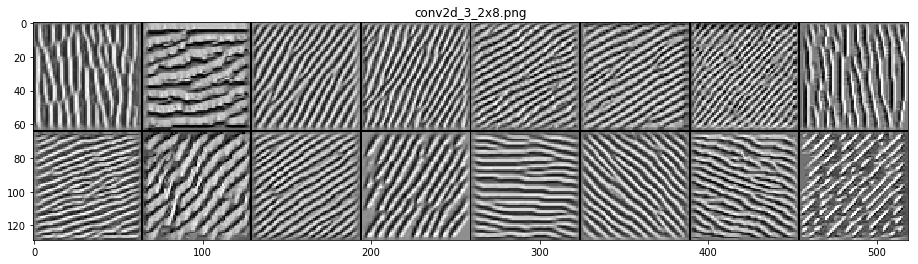

In [5]:
visualize_layer(model,model.layers[0].name,filter_range=(0,32),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[3].name,filter_range=(0,16),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

## With Modifications

In [12]:
X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=2,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     horizontal_flip=False)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,)

print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (X_train.mean(), X_train.std(), X_test.mean(), X_test.std()))

datagen.fit(X_train)
print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))
# demonstrate effect on a single batch of samples
iterator = datagen.flow(X_train, Y_train, batch_size=64)
print("generator length = ",len(iterator)," Steps = ",len(X_train)/64)
# get a batch
batchX, batchy = iterator.next()
# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())
# demonstrate effect on entire training dataset
iterator = datagen.flow(X_train, Y_train, batch_size=len(X_train), shuffle=False)
# get a batch
batchX, batchy = iterator.next()
# pixel stats in the full set
print(batchX.shape, batchX.mean(), batchX.std())


Statistics train=33.318 (78.567), test=33.791 (79.172)
Data Generator mean=33.318, std=78.568
generator length =  938  Steps =  937.5
(64, 28, 28, 1) 0.010806842 1.0072671
(60000, 28, 28, 1) -2.5048548e-08 0.9999993


### ImageNorm: Without any LR tuning

In [6]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.41%

Params =  12846

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_25', 'dropout_16', 'conv2d_26', 'conv2d_27', 'dropout_17', 'max_pooling2d_4', 'conv2d_28', 'dropout_18', 'conv2d_29', 'dropout_19', 'conv2d_30', 'dropout_20', 'conv2d_31', 'conv2d_32', 'flatten_4', 'activation_17']
Validation Loss (0.02197951868996024, 0.9937)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.006211339428027471, 0.9984333334604899]
Balanced Accuracy = 99.84% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.021188561891019

### BatchNorm: Without any LR tuning

In [4]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16, 3,3,)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3,)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,)) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,)) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(
    rescale=1/255)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.56% 99.43% 99.42% 99.55% 99.37%

Params =  13310

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_9', 'batch_normalization_1', 'activation_2', 'dropout_6', 'conv2d_10', 'batch_normalization_2', 'activation_3', 'conv2d_11', 'batch_normalization_3', 'activation_4', 'dropout_7', 'max_pooling2d_2', 'conv2d_12', 'batch_normalization_4', 'activation_5', 'dropout_8', 'conv2d_13', 'batch_normalization_5', 'activation_6', 'dropout_9', 'conv2d_14', 'batch_normalization_6', 'activation_7', 'dropout_10', 'conv2d_15', 'batch_normalization_7', 'activation_8', 'conv2d_16', 'flatten_2', 'activation_9']
Validation Loss (0.021757944977283478, 0.9937999997138977)
 =-=  =-=  =-= 

No BN before last layer

In [5]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16, 3,3,)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3,)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,)) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(
    rescale=1/255)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_= inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.47% 99.44% 99.46% 99.50% 99.50%

Params =  13270

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_17', 'batch_normalization_8', 'activation_10', 'dropout_11', 'conv2d_18', 'batch_normalization_9', 'activation_11', 'conv2d_19', 'batch_normalization_10', 'activation_12', 'dropout_12', 'max_pooling2d_3', 'conv2d_20', 'batch_normalization_11', 'activation_13', 'dropout_13', 'conv2d_21', 'batch_normalization_12', 'activation_14', 'dropout_14', 'conv2d_22', 'batch_normalization_13', 'activation_15', 'dropout_15', 'conv2d_23', 'conv2d_24', 'flatten_3', 'activation_16']
Validation Loss (0.019299040032178163, 0.9944999999046326)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 

### L2 Reg: Without any LR tuning

In [3]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Convolution2D(16, 3,3, kernel_regularizer=l2(0.001), activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, kernel_regularizer=l2(0.001), activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, kernel_regularizer=l2(0.001), activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, kernel_regularizer=l2(0.001), activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, kernel_regularizer=l2(0.001), activation='relu')) #6
model.add(Convolution2D(10, 6,6, kernel_regularizer=l2(0.001),))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(
    rescale=1/255)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.30%

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Params =  12846
Instructions for updating:
Use tf.cast instead.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.
Layer Names:  ['conv2d_1', 'dropout_1', 'conv2d_2', 'conv2d_3', 'dropout_2', 'max_pooling2d_1', 'conv2d_4', 'dropout_3', 'conv2d_5', 'dropout_4', 'conv2d_6', 'dropout_5', 'conv2d_7', 'conv2d_8', 'flatten_1', 'activation_1']
Validation Loss (0.07012515564560891, 0.9920999999046326)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.06884608489274979, 0.99395000

### Putting All Together and LR Tuning (No Arch Changes)

In [36]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,kernel_regularizer=l2(0.001), input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.001),))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.001),)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.001),)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.001),)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.001),)) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.001),)) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(10, 6,6,kernel_regularizer=l2(0.001),))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")


iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.57% 99.55% 99.49%

Params =  13310

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.
Layer Names:  ['conv2d_162', 'batch_normalization_117', 'activation_129', 'dropout_96', 'conv2d_163', 'batch_normalization_118', 'activation_130', 'conv2d_164', 'batch_normalization_119', 'activation_131', 'dropout_97', 'max_pooling2d_38', 'conv2d_165', 'batch_normalization_120', 'activation_132', 'dropout_98', 'conv2d_166', 'batch_normalization_121', 'activation_133', 'dropout_99', 'conv2d_167', 'batch_normalization_122', 'activation_134', 'dropout_100', 'conv2d_168', 'batch_normalization_123', 'activation_135', 'conv2d_169', 'flatten_23', 'activation_136']
Validation Loss (0.0322409304767847, 0.9943999999046326)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =

### Showing 25 Misclassified examples

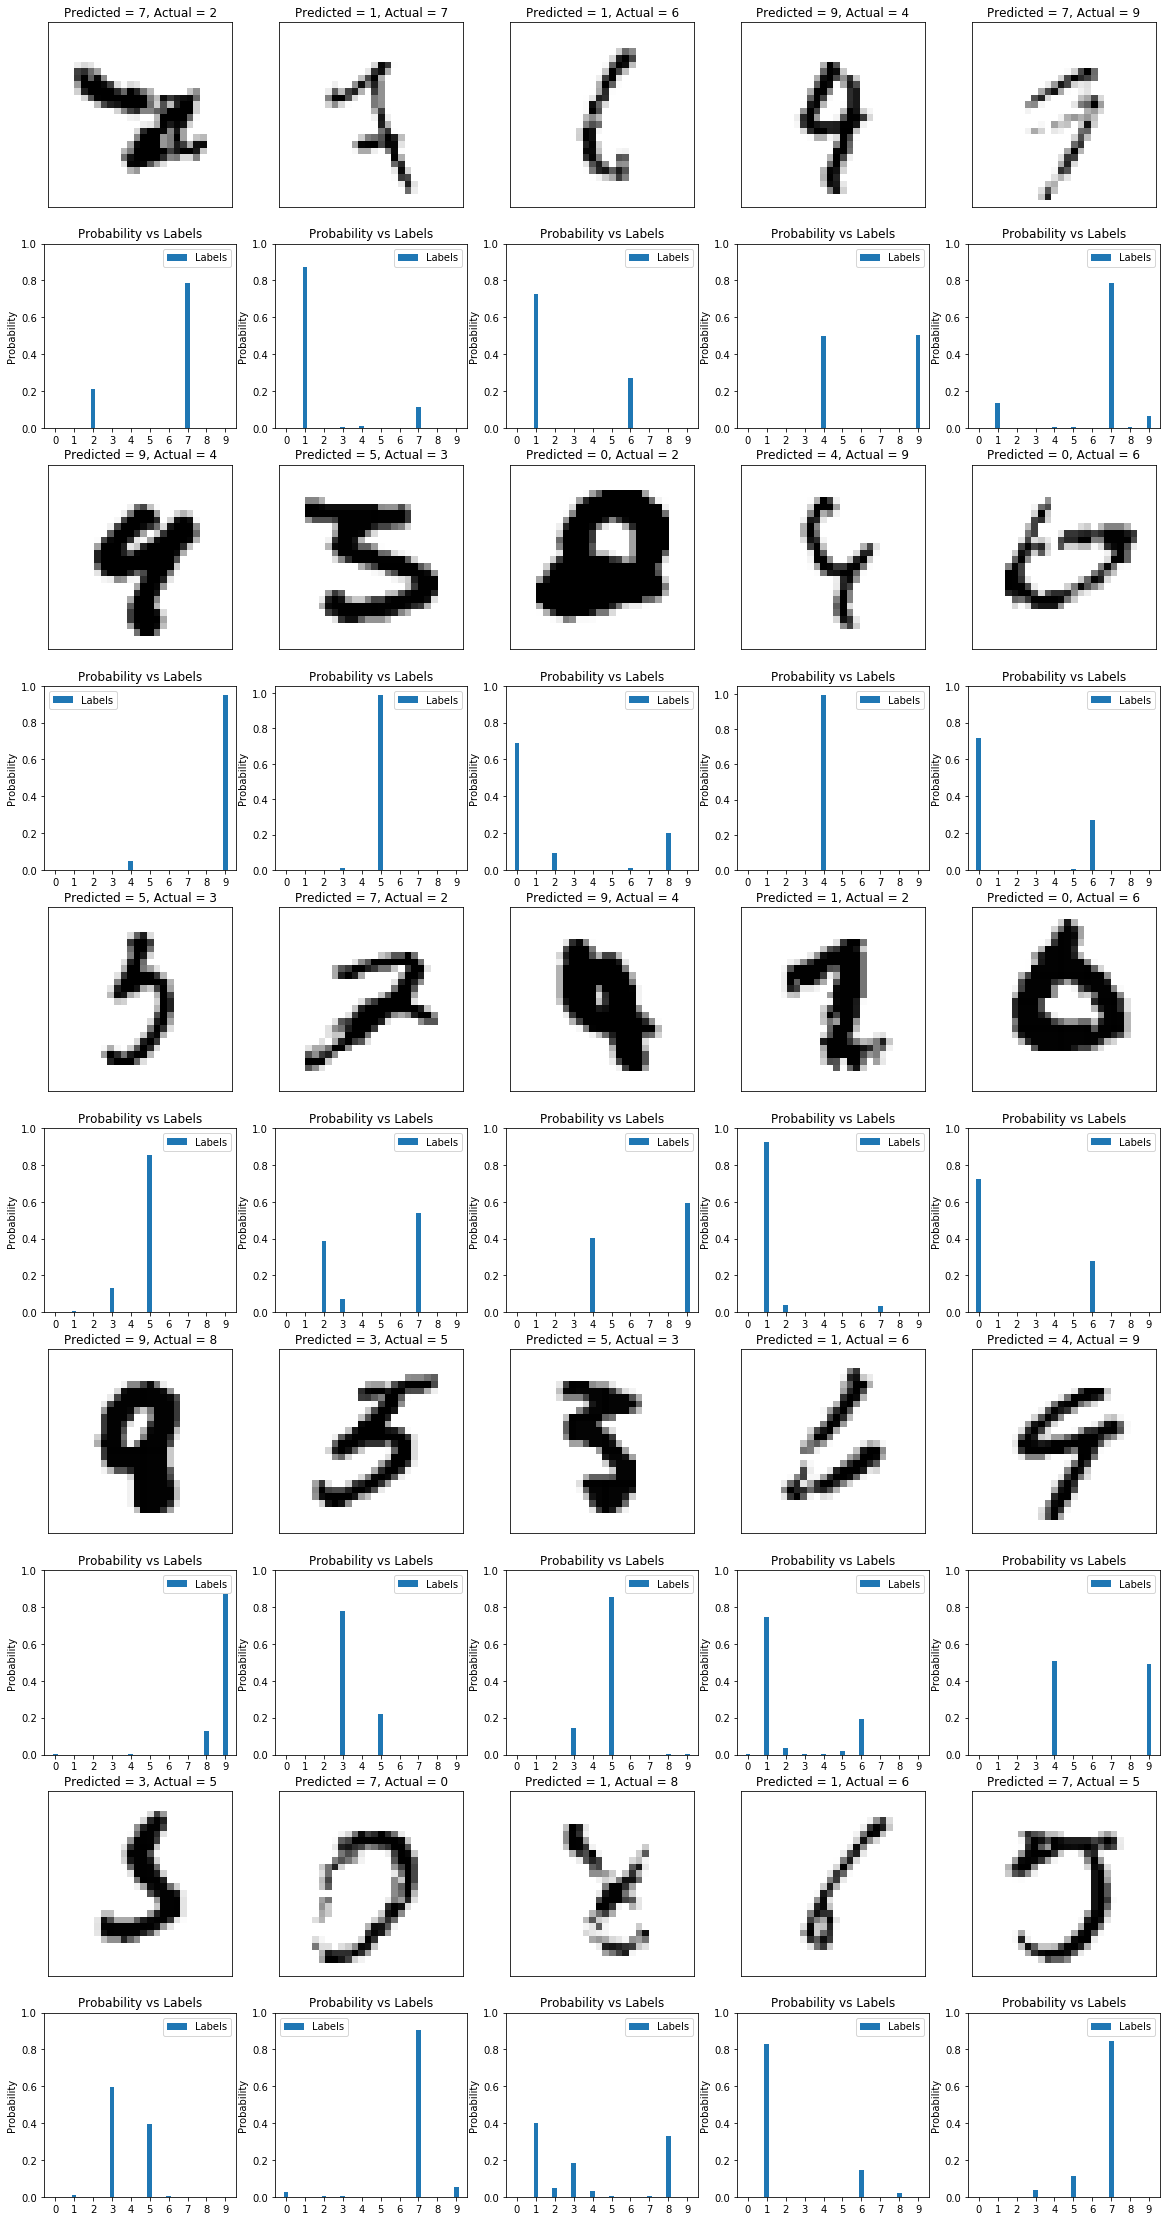

In [16]:
show_misclassified(X_test, Y_test, predictions[:len(Y_test)], classes=get_mnist_labels(), 
                       columns=5, total=25, 
                       pick_randomly=True, image_size_multiplier=4)

# Architecture 17 SpatialDropout2D in initial 2 layers only
- SpatialDropout2D is useful only in initial layers where pixels are highly correlated to each other in the same channel

## Vanilla Network from assignment - 4 (Our control group)

In [0]:
X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=True)

In [25]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,), activation='relu')) # 10
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,), activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=40, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.41% with 200 epochs
# 99.22%, 99.10%  with 40 epochs

Params =  5094
Layer Names:  ['conv2d_88', 'spatial_dropout2d_7', 'conv2d_89', 'dropout_59', 'conv2d_90', 'max_pooling2d_18', 'conv2d_91', 'dropout_60', 'conv2d_92', 'dropout_61', 'conv2d_93', 'dropout_62', 'max_pooling2d_19', 'conv2d_94', 'flatten_13', 'activation_13']
Validation Loss (0.03200420580804348, 0.9890999996185302)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  5094
Score =  [0.01726526223422649, 0.99505]
Balanced Accuracy = 99.50% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  5094
Score =  [0.028582529043080285, 0.9911]
Balanced Accuracy = 99.10% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [3.3811986, 4.016002, 4.8080616, 4.397747, 8.786864, 4.5181365, 4.4017878, 0.0]


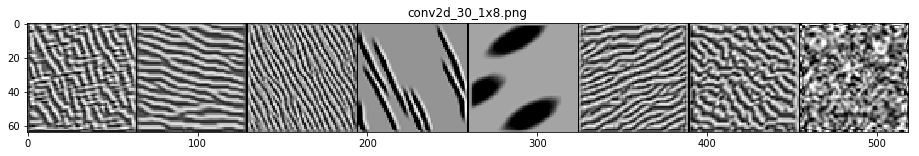

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [5.386033, 14.497066, 20.821, 2.8976245, 4.1635227, 13.128895, 6.7732906, 1.6614808, 7.5404005, 2.859163, 2.6667843, 3.7453249, 8.444021, 13.159994, 0.0, 9.954837]


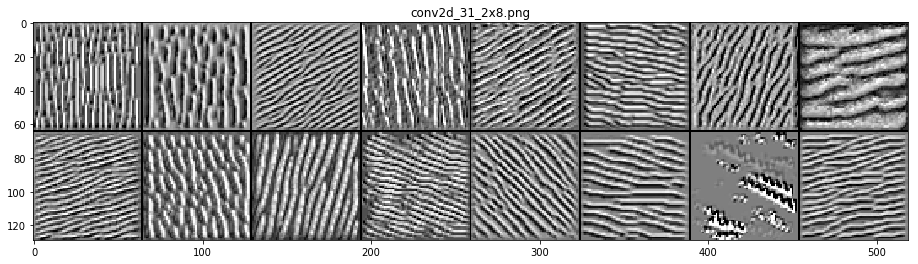

In [16]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=10)
visualize_layer(model,model.layers[2].name,filter_range=(0,16),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=10)

## With Modifications

### ImageNorm: Without any LR tuning

In [17]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,), activation='relu')) # 10
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,), activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.17%


Params =  5094
Layer Names:  ['conv2d_41', 'spatial_dropout2d_1', 'conv2d_42', 'dropout_26', 'conv2d_43', 'max_pooling2d_6', 'conv2d_44', 'dropout_27', 'conv2d_45', 'dropout_28', 'conv2d_46', 'dropout_29', 'max_pooling2d_7', 'conv2d_47', 'flatten_6', 'activation_26']
Validation Loss (0.032616788923740384, 0.9907999997138977)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.018618705931305886, 0.9943333335876465]
Balanced Accuracy = 99.43% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.02849182658493519, 0.9918000002861023]
Balanced Accuracy = 99.17% 


### BatchNorm: Without any LR tuning

In [29]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3,)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(BatchNormalization())


model.add(Convolution2D(8, (3,3,),)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,),)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(rescale=1/255)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.24% 99.24% 99.16%

Params =  5446
Layer Names:  ['conv2d_111', 'batch_normalization_71', 'activation_78', 'spatial_dropout2d_11', 'conv2d_112', 'batch_normalization_72', 'activation_79', 'dropout_66', 'conv2d_113', 'batch_normalization_73', 'activation_80', 'max_pooling2d_26', 'batch_normalization_74', 'conv2d_114', 'batch_normalization_75', 'activation_81', 'dropout_67', 'conv2d_115', 'batch_normalization_76', 'activation_82', 'dropout_68', 'conv2d_116', 'batch_normalization_77', 'activation_83', 'dropout_69', 'max_pooling2d_27', 'batch_normalization_78', 'conv2d_117', 'flatten_16', 'activation_84']
Validation Loss (0.030970744270086288, 0.9912999998092651)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.015514281113942464, 0.9952666668574015]
Balanced Accuracy = 99.52% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.02362106211185455, 0.9917999981880188]
Balanced Accuracy =

No BN before Last layer

In [30]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3,)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,),)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,),)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(rescale=1/255)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.31% 99.31%

Params =  5366
Layer Names:  ['conv2d_118', 'batch_normalization_79', 'activation_85', 'spatial_dropout2d_12', 'conv2d_119', 'batch_normalization_80', 'activation_86', 'dropout_70', 'conv2d_120', 'batch_normalization_81', 'activation_87', 'max_pooling2d_28', 'conv2d_121', 'batch_normalization_82', 'activation_88', 'dropout_71', 'conv2d_122', 'batch_normalization_83', 'activation_89', 'dropout_72', 'conv2d_123', 'batch_normalization_84', 'activation_90', 'dropout_73', 'max_pooling2d_29', 'conv2d_124', 'flatten_17', 'activation_91']
Validation Loss (0.02615254819393158, 0.9922999997138977)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.012237306753794351, 0.9964166669209799]
Balanced Accuracy = 99.64% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.023913879941403867, 0.9936000001907349]
Balanced Accuracy = 99.35% 


### L2 Reg: Without any LR tuning

In [23]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu',kernel_regularizer=l2(0.0001), input_shape=(28,28,1))) # 26
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.0001), activation='relu')) # 24
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.0001), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,),kernel_regularizer=l2(0.0001), activation='relu')) # 10
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,),kernel_regularizer=l2(0.0001), activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.0001), activation='relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4, kernel_regularizer=l2(0.0001),))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.23%


Params =  5094
Layer Names:  ['conv2d_76', 'spatial_dropout2d_6', 'conv2d_77', 'dropout_46', 'conv2d_78', 'max_pooling2d_16', 'conv2d_79', 'dropout_47', 'conv2d_80', 'dropout_48', 'conv2d_81', 'dropout_49', 'max_pooling2d_17', 'conv2d_82', 'flatten_11', 'activation_49']
Validation Loss (0.05582065427303314, 0.9893999995231628)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.04520080153743426, 0.9925833331108094]
Balanced Accuracy = 99.25% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.04725737465023994, 0.9923000002861023]
Balanced Accuracy = 99.23% 


### Putting All Together and LR Tuning (No Arch Changes)

In [37]:
model = Sequential()
model.add(Convolution2D(8, 3, 3,kernel_regularizer=l2(0.0001), input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(16, 3,3,kernel_regularizer=l2(0.0001),)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.0001),))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,),kernel_regularizer=l2(0.0001),)) # 10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(16, (3,3,),kernel_regularizer=l2(0.0001),)) # 8
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1,kernel_regularizer=l2(0.0001),))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4,kernel_regularizer=l2(0.0001),))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])



X_train, Y_train, X_test, Y_test = get_mnist_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)

datagen.fit(X_train)
train_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=512,shuffle=True),
                    steps_per_epoch=int(np.ceil(len(X_train)/512)), 
                    epochs=40, verbose=0, validation_data=datagen.flow(X_test, Y_test, batch_size=512,shuffle=True), 
                    validation_steps = int(np.ceil(len(X_test)/512)), 
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

# steps=np.ceil(len(X_train)/1024)
# since it is auto calculated by kera so don't fill  it

iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_mnist_labels(),print_results=True, plot_results=False)


iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.20% 99.35% 99.40%

Params =  5366
Layer Names:  ['conv2d_170', 'batch_normalization_124', 'activation_137', 'spatial_dropout2d_16', 'conv2d_171', 'batch_normalization_125', 'activation_138', 'dropout_101', 'conv2d_172', 'batch_normalization_126', 'activation_139', 'max_pooling2d_39', 'conv2d_173', 'batch_normalization_127', 'activation_140', 'dropout_102', 'conv2d_174', 'batch_normalization_128', 'activation_141', 'dropout_103', 'conv2d_175', 'batch_normalization_129', 'activation_142', 'dropout_104', 'max_pooling2d_40', 'conv2d_176', 'flatten_24', 'activation_143']
Validation Loss (0.029987261128425598, 0.9936999998092652)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.0210513174811999, 0.9977666668574016]
Balanced Accuracy = 99.77% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.029949535953998567, 0.9941000003814697]
Balanced Accuracy = 99.40% 


### Showing 25 Misclassified examples

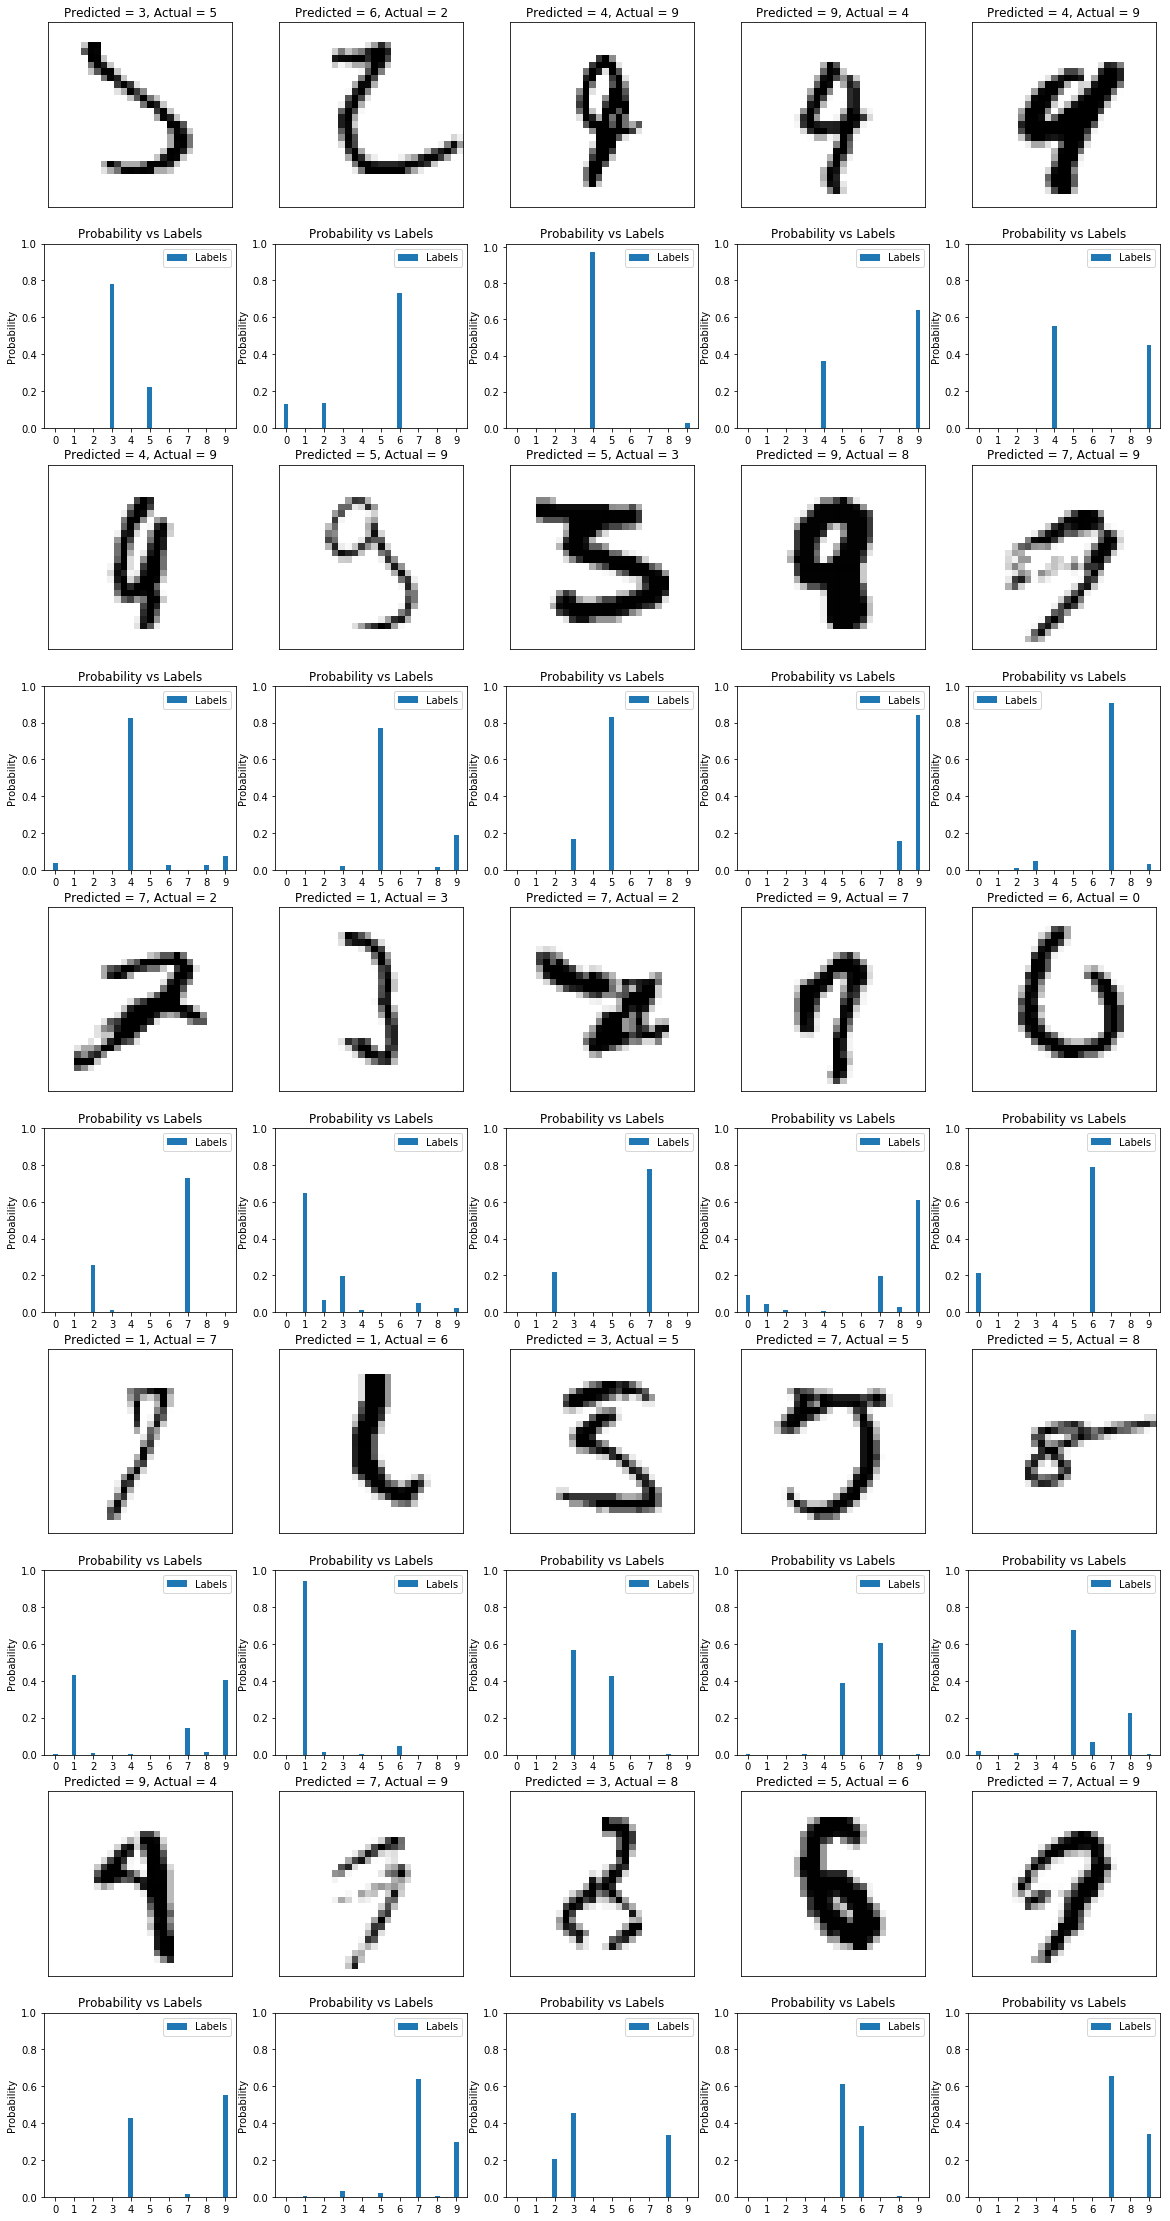

In [38]:
show_misclassified(X_test, Y_test, predictions[:len(Y_test)], classes=get_mnist_labels(), 
                       columns=5, total=25, 
                       pick_randomly=True, image_size_multiplier=4)